In [9]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Read dataset
df = pd.read_csv("ufc-master.csv")

df.head()

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Date,Location,Country,Winner,...,FinishDetails,FinishRound,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds
0,Jared Cannonier,Nassourdine Imavov,110.0,-130.0,110.0000,76.9231,2024-06-08,"Louisville, Kentucky, USA",USA,Blue,...,Punches,4.0,1:34,994.0,250.0,240.0,2000.0,700.0,350.0,300.0
1,Dominick Reyes,Dustin Jacoby,190.0,-250.0,190.0000,40.0000,2024-06-08,"Louisville, Kentucky, USA",USA,Red,...,Punches,1.0,2:00,120.0,500.0,240.0,1600.0,1600.0,500.0,120.0
2,Raul Rosas Jr.,Ricky Turcios,-298.0,220.0,33.5570,220.0000,2024-06-08,"Louisville, Kentucky, USA",USA,Red,...,Rear Naked Choke,2.0,2:22,442.0,200.0,300.0,200.0,1600.0,600.0,1000.0
3,Brunno Ferreira,Dustin Stoltzfus,-285.0,230.0,35.0877,230.0000,2024-06-08,"Louisville, Kentucky, USA",USA,Red,...,Spinning Back Elbow,1.0,4:51,291.0,650.0,600.0,800.0,550.0,-135.0,900.0
4,Julian Marquez,Zachary Reese,-145.0,114.0,68.9655,114.0000,2024-06-08,"Louisville, Kentucky, USA",USA,Blue,...,Punch,1.0,0:20,20.0,600.0,1100.0,450.0,450.0,175.0,300.0




##Exploratory Data Analysis

Dataset Shape: (8343, 118)
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8343 entries, 0 to 8342
Columns: 118 entries, RedFighter to BKOOdds
dtypes: bool(1), float64(60), int64(43), object(14)
memory usage: 7.5+ MB
None

Missing Values:
RedFighter             0
BlueFighter            0
RedOdds              720
BlueOdds             721
RedExpectedValue     720
                    ... 
BlueDecOdds         1664
RSubOdds            1890
BSubOdds            1907
RKOOdds             1876
BKOOdds             1908
Length: 118, dtype: int64


<ipython-input-11-f69a0c871b63>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Winner', data=df, palette='Set1')


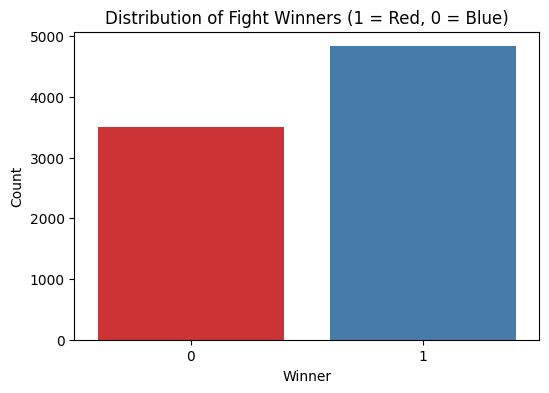

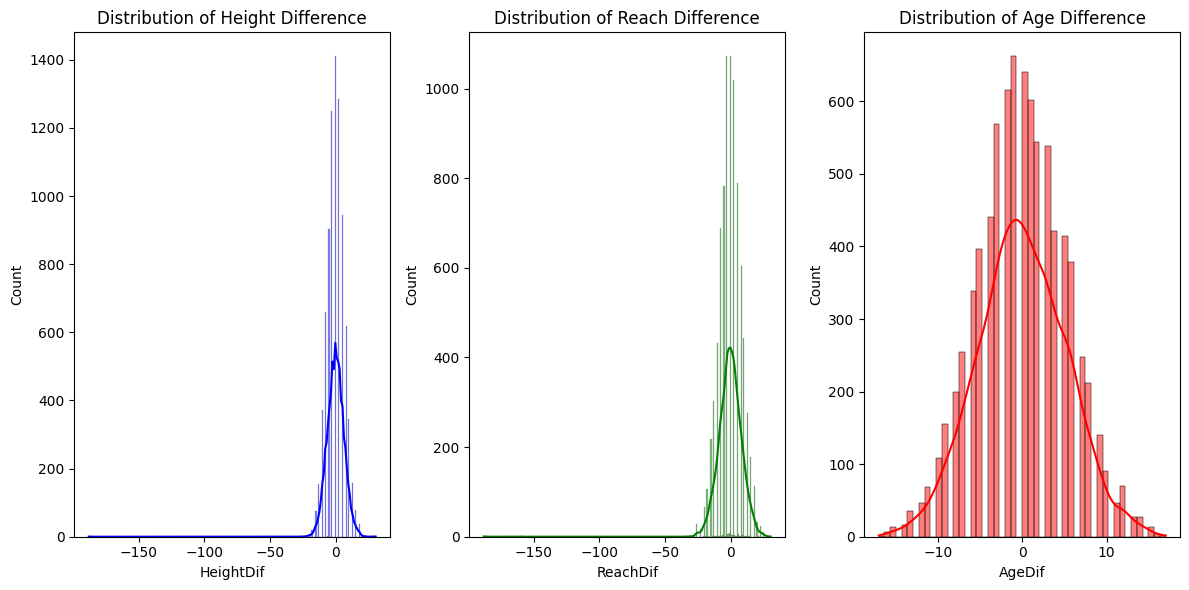

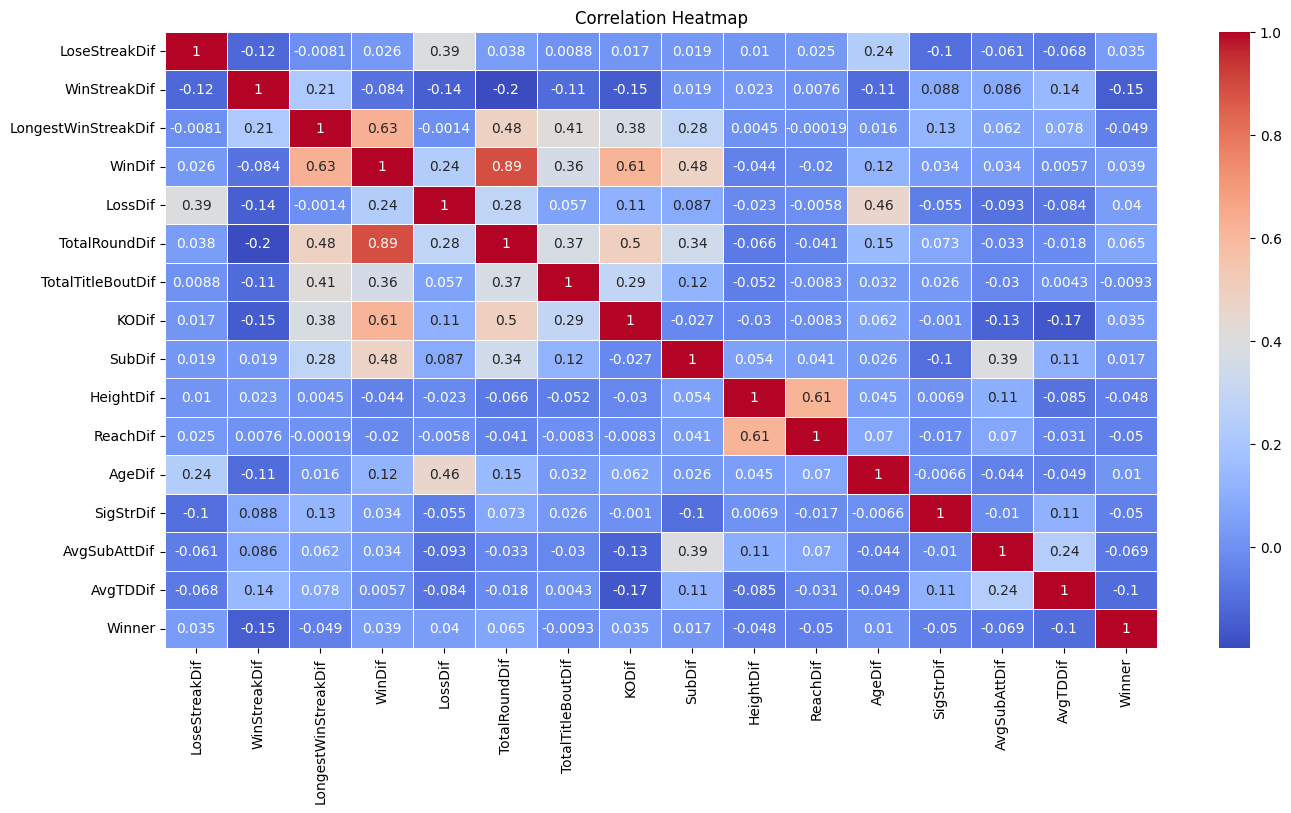

In [11]:
#General Data Summary
print("Dataset Shape:", df.shape)
print("Dataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

# Distribution of Target Variable (Winner)
# Convert Winner to binary values (1 for Red, 0 for Blue)
df.loc[df['Winner'] == "Red", 'Winner'] = 1
df.loc[df['Winner'] == "Blue", 'Winner'] = 0

# Plot the distribution of winners (Red vs Blue)
plt.figure(figsize=(6, 4))
sns.countplot(x='Winner', data=df, palette='Set1')
plt.title('Distribution of Fight Winners (1 = Red, 0 = Blue)')
plt.xlabel('Winner')
plt.ylabel('Count')
plt.show()

# Feature Distributions
# Let's look at some numerical features: HeightDif, ReachDif, AgeDif
plt.figure(figsize=(12, 6))

# Height Difference Distribution
plt.subplot(1, 3, 1)
sns.histplot(df['HeightDif'].dropna(), kde=True, color='blue')
plt.title('Distribution of Height Difference')

# Reach Difference Distribution
plt.subplot(1, 3, 2)
sns.histplot(df['ReachDif'].dropna(), kde=True, color='green')
plt.title('Distribution of Reach Difference')

# Age Difference Distribution
plt.subplot(1, 3, 3)
sns.histplot(df['AgeDif'].dropna(), kde=True, color='red')
plt.title('Distribution of Age Difference')

plt.tight_layout()
plt.show()

# Correlation Heatmap
# important numerical features for correlation analysis
numeric_features = ['LoseStreakDif', 'WinStreakDif', 'LongestWinStreakDif', 'WinDif',
                    'LossDif', 'TotalRoundDif', 'TotalTitleBoutDif', 'KODif', 'SubDif',
                    'HeightDif', 'ReachDif', 'AgeDif', 'SigStrDif', 'AvgSubAttDif', 'AvgTDDif', 'Winner']

# Compute the correlation matrix
corr_matrix = df[numeric_features].corr()

# Plot heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

**probability that the lower-ranked player won**




In [12]:
filtered_df = df[df["BetterRank"] != "neither"]
# the number of rows with rank info
total_row_num = filtered_df.shape[0]

lower_rank_won_num = filtered_df[
    ((filtered_df["BetterRank"] == "Red") & (filtered_df["Winner"] == 0))
    | ((filtered_df["BetterRank"] == "Blue") & (filtered_df["Winner"] == 1))
].shape[0]

print("total_row_num = " + str(total_row_num))
print("lower_rank_won_num = " + str(lower_rank_won_num))

probability = lower_rank_won_num / total_row_num
print(f'The probability that the lower-ranked player won is: {probability}')

total_row_num = 2454
lower_rank_won_num = 1040
The probability that the lower-ranked player won is: 0.42379788101059496


**predict winners using only the favorite variable:**



In [14]:
# Odds Model

# print(df.Winner.unique())

# There are only 6 draws in UFC history, so this outcome can be safely ignored. Those are not in this dataset

# Convert target variable into binary values

df.loc[df['Winner'] == "Red", 'Winner'] = 1
df.loc[df['Winner'] == "Blue", 'Winner'] = 0

# Create feature that says if Red is favorite or no

df['Red_Favorite'] = df.apply(lambda row: (row.RedOdds < 0)&(row.BlueOdds > 0), axis = 1)
df.loc[df['Red_Favorite'] == True, 'Red_Favorite'] = 1
df.loc[df['Red_Favorite'] == False, 'Red_Favorite'] = 0

# Let's see the accuracy of a predictive model based on only one variable: Predict that the favorite to win will win

acc = (df[((df.Red_Favorite == 1) & (df.Winner == 1))|((df.Red_Favorite == 0) & (df.Winner == 0))].shape[0])/(df.shape[0])

print("Betting on the favorite:", acc) # It's actually not too bad, we get a 65% accuracy. So, more often than not, it's a good idea to bet on the favorite

# What if we bet on the underdog? Let's check

acc = (df[((df.Red_Favorite == 1) & (df.Winner == 0))|((df.Red_Favorite == 0) & (df.Winner == 1))].shape[0])/(df.shape[0])
print("Betting on the underdog:", acc) # That is expected, it's just 1 - P(Favorite Wins)

# So, this should be a very useful feature to predict outcomes! But can we do better without using it?

# Let's see!


Betting on the favorite: 0.6413760038355507
Betting on the underdog: 0.35862399616444923


<ipython-input-14-14390efc609f>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[df['Red_Favorite'] == True, 'Red_Favorite'] = 1


##Logistic Regression


**Logistic model using certain features:**

In [17]:
y = df['Winner'] # Target
label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(y)


X = []
X = df[
        [
            "LoseStreakDif",
            "WinStreakDif",
            "LongestWinStreakDif",
            "WinDif",
            "LossDif",
            "TotalRoundDif",
            "TotalTitleBoutDif",
            "KODif",
            "SubDif",
            "HeightDif",
            "ReachDif",
            "AgeDif",
            "SigStrDif",
            "AvgSubAttDif",
            "AvgTDDif",
        ]
    ]

X = pd.DataFrame(
    X,
    columns=[
        "LoseStreakDif",
        "WinStreakDif",
        "LongestWinStreakDif",
        "WinDif",
        "LossDif",
        "TotalRoundDif",
        "TotalTitleBoutDif",
        "KODif",
        "SubDif",
        "HeightDif",
        "ReachDif",
        "AgeDif",
        "SigStrDif",
        "AvgSubAttDif",
        "AvgTDDif",
    ],
)

X = sm.add_constant(X) # Add constant

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

# Fit a logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Make predictions and calculate accuracy
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'Training Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

# Coefficients and Odds Ratios
coefficients = log_reg.coef_[0]
odds_ratios = np.exp(coefficients)


# Display feature importance using coefficients and odds ratios
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios
})
print("\nFeature Importance (Coefficient and Odds Ratio):")
print(feature_importance.sort_values(by='Coefficient', ascending=False))

Training Accuracy: 0.6083308360803117
Test Accuracy: 0.5871779508687837

Feature Importance (Coefficient and Odds Ratio):
                Feature  Coefficient  Odds Ratio
0                 const     0.149973    1.161803
9                SubDif     0.067621    1.069960
1         LoseStreakDif     0.020984    1.021205
8                 KODif     0.012990    1.013075
6         TotalRoundDif     0.010105    1.010156
13            SigStrDif    -0.001114    0.998887
12               AgeDif    -0.001940    0.998062
10            HeightDif    -0.005345    0.994670
11             ReachDif    -0.009707    0.990340
5               LossDif    -0.011524    0.988542
4                WinDif    -0.018947    0.981231
3   LongestWinStreakDif    -0.045877    0.955159
7     TotalTitleBoutDif    -0.046014    0.955028
15             AvgTDDif    -0.104640    0.900648
2          WinStreakDif    -0.125605    0.881963
14         AvgSubAttDif    -0.131417    0.876852


**Logistic model using all of the variables except favorite, to compare with previous prediction:**

In [21]:
# Let's try using a logistic regression with a bunch of features

y = df['Winner'] # Target
label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(y)

label_binarizer = LabelBinarizer() # Those are categorical variables

T_bout = label_binarizer.fit_transform(df['TitleBout']) # 1 Yes, 0 No
W_class = label_binarizer.fit_transform(df['WeightClass']) # Bantamweight, Catch Weight, Featherweight, Flyweight, Heavyweight, Light Heavyweight, Lightweight, Middleweight, Welterweight, Women's Bantamweight, Women's Featherweight, Women's Flyweight, Women's Strawweight
G = label_binarizer.fit_transform(df['Gender']) # 1 Male, 0 Female
R_Stance = label_binarizer.fit_transform(df['RedStance']) # Open Stance, Orthodox, Southpaw, Switch
B_stance = label_binarizer.fit_transform(df['BlueStance']) # Open Stance, Orthodox, Southpaw, Switch

X = []
X = np.append(T_bout, W_class, axis = 1)
X = np.append(X, G, axis = 1)
X = np.append(X, R_Stance, axis = 1)
X = np.append(X, B_stance, axis = 1)

X = np.append(X, df[['LoseStreakDif', 'WinStreakDif', 'LongestWinStreakDif', 'WinDif', 'LossDif', 'TotalRoundDif', 'TotalTitleBoutDif', 'KODif', 'SubDif',
        'HeightDif', 'ReachDif', 'AgeDif', 'SigStrDif', 'AvgSubAttDif', 'AvgTDDif']], axis = 1) # Features, can add 'Red_Favorite'

X = pd.DataFrame(X, columns = ['TitleBout', 'WC_Bantam', 'WC_Catch', 'WC_Feather', 'WC_Fly', 'WC_Heavy',
        'WC_LHeavy', 'WC_Light', 'WC_Middle', 'WC_Welter', 'WC_Bantam_F', 'WC_Feather_F', 'WC_Fly_F', 'WC_Straw_F',
        'Gender', 'R_Stance_Open', 'R_Stance_Ortho', 'R_Stance_South', 'R_Stance_Switch', 'B_Stance_Open', 'B_Stance_Ortho',
        'B_Stance_South', 'B_Stance_Switch', 'LoseStreakDif', 'WinStreakDif', 'LongestWinStreakDif', 'WinDif', 'LossDif', 'TotalRoundDif',
        'TotalTitleBoutDif', 'KODif', 'SubDif', 'HeightDif', 'ReachDif', 'AgeDif', 'SigStrDif', 'AvgSubAttDif', 'AvgTDDif'])

X = sm.add_constant(X) # Add constant

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

# Fit a logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Make predictions and calculate accuracy
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(train_accuracy, test_accuracy) # So we do not, actually. But we get some interesting insights into what determines a winner!

# Coefficients and Odds Ratios
coefficients = log_reg.coef_[0]
odds_ratios = np.exp(coefficients)


# Display feature importance using coefficients and odds ratios
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios
})
print("\nFeature Importance (Coefficient and Odds Ratio):")
print(feature_importance.sort_values(by='Coefficient', ascending=False))


TypeError: '<' not supported between instances of 'float' and 'str'

# Decision Tree

Unpruned Tree - Training Accuracy: 0.9992508240934972
Unpruned Tree - Test Accuracy: 0.6824445775913721


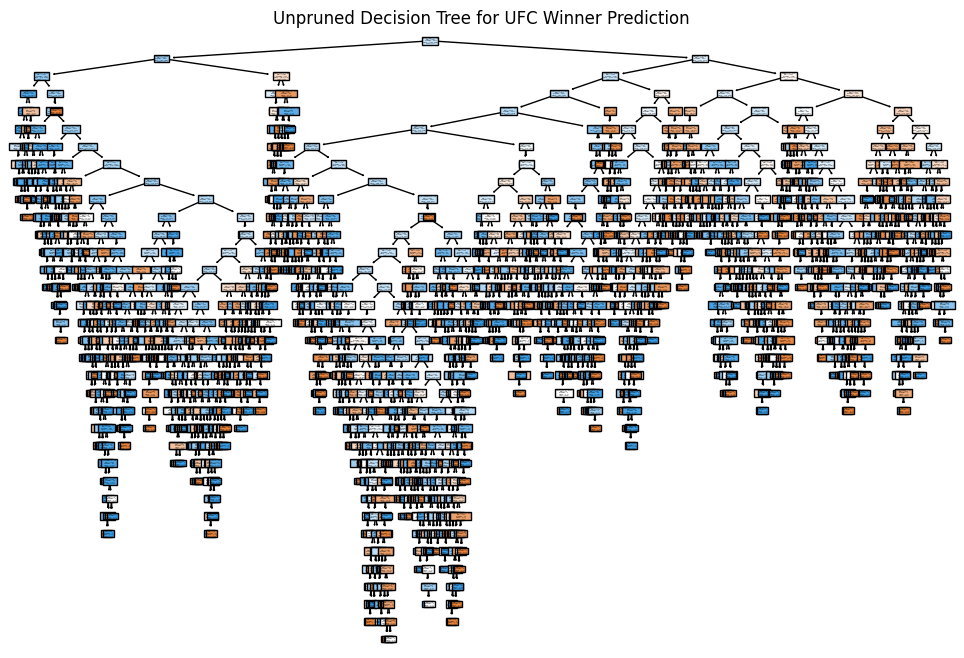

Best ccp_alpha: 0.000559102663011767
Pruned Tree - Training Accuracy: 0.7694036559784238
Pruned Tree - Test Accuracy: 0.6818454164170161


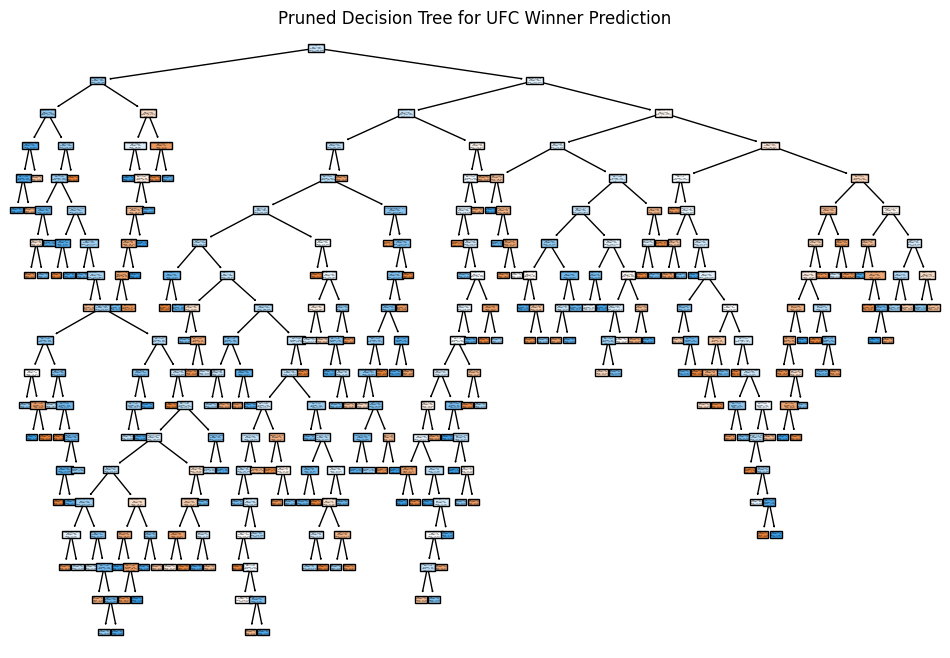

In [22]:
# BE PATIENT, this took roughly 90s on my computer, 4min here

df.loc[df['Winner'] == "Red", 'Winner'] = 1
df.loc[df['Winner'] == "Blue", 'Winner'] = 0
df['Winner'] = pd.to_numeric(df['Winner'])

features = ['LoseStreakDif', 'WinStreakDif', 'LongestWinStreakDif', 'WinDif', 'LossDif',
            'TotalRoundDif', 'TotalTitleBoutDif', 'KODif', 'SubDif', 'HeightDif',
            'ReachDif', 'AgeDif', 'SigStrDif', 'AvgSubAttDif', 'AvgTDDif']
X = df[features]
y = df['Winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

### Unpruned Tree ###

# Train the unpruned decision tree
unpruned_clf = DecisionTreeClassifier(random_state=13)
unpruned_clf.fit(X_train, y_train)

y_train_pred_unpruned = unpruned_clf.predict(X_train)
y_test_pred_unpruned = unpruned_clf.predict(X_test)

train_accuracy_unpruned = accuracy_score(
    y_train, y_train_pred_unpruned
)  # obviously overfit the data
test_accuracy_unpruned = accuracy_score(y_test, y_test_pred_unpruned)

print(f'Unpruned Tree - Training Accuracy: {train_accuracy_unpruned}')
print(f'Unpruned Tree - Test Accuracy: {test_accuracy_unpruned}')

# Plot the unpruned tree
plt.figure(figsize=(12, 8))
plot_tree(unpruned_clf, feature_names=features, class_names=['Blue', 'Red'], filled=True)
plt.title('Unpruned Decision Tree for UFC Winner Prediction')
plt.show()


### Pruned Tree (Cost Complexity Pruning) ###

# Compute the pruning path to get possible ccp_alpha values
clf = DecisionTreeClassifier(random_state=13)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Train a tree for each ccp_alpha and use cross-validation to find the best alpha
clfs = []
cv_scores = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=13, ccp_alpha=ccp_alpha)
    # Perform 5-fold cross-validation to determine the best ccp_alpha
    scores = cross_val_score(
        clf, X_train, y_train, cv=5, scoring="neg_mean_squared_error"
    )
    clfs.append(clf)
    cv_scores.append(np.mean(scores))

# Select the best ccp_alpha based on the cross-validation scores
best_index = np.argmax(cv_scores)
best_ccp_alpha = ccp_alphas[best_index]
best_clf = clfs[best_index]

print(f'Best ccp_alpha: {best_ccp_alpha}')

# Train the final model with the best ccp_alpha on the entire training set
best_clf.fit(X_train, y_train)

y_train_pred_pruned = best_clf.predict(X_train)
y_test_pred_pruned = best_clf.predict(X_test)

train_accuracy_pruned = accuracy_score(y_train, y_train_pred_pruned)
test_accuracy_pruned = accuracy_score(y_test, y_test_pred_pruned)

print(f'Pruned Tree - Training Accuracy: {train_accuracy_pruned}')
print(f'Pruned Tree - Test Accuracy: {test_accuracy_pruned}')

# Plot the pruned decision tree
plt.figure(figsize=(12, 8))
plot_tree(best_clf, feature_names=features, class_names=['Blue', 'Red'], filled=True)
plt.title('Pruned Decision Tree for UFC Winner Prediction')
plt.show()

# Multilayer Perceptron Model

In [ ]:
from sklearn.neural_network import MLPClassifier

df.loc[df['Winner'] == "Red", 'Winner'] = 1
df.loc[df['Winner'] == "Blue", 'Winner'] = 0
df['Winner'] = pd.to_numeric(df['Winner'])

# Define the feature columns and the target column
features = ['LoseStreakDif', 'WinStreakDif', 'LongestWinStreakDif', 'WinDif', 'LossDif',
            'TotalRoundDif', 'TotalTitleBoutDif', 'KODif', 'SubDif', 'HeightDif',
            'ReachDif', 'AgeDif', 'SigStrDif', 'AvgSubAttDif', 'AvgTDDif']
X = df[features]
y = df['Winner']

# test/train split, using the same random seed as the decision tree model for comparison
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

mlp = MLPClassifier(max_iter=500, random_state=13, batch_size = 250)

# cross validation to determine best parameters
param_grid = {
    'hidden_layer_sizes': [(20,), (50,), (100,), (150,)],
    'alpha': [0.0001, 0.001, 0.01],
}
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
mlp.set_params(**grid_search.best_params_)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))

{'alpha': 0.0001, 'hidden_layer_sizes': (20,)}
Accuracy: 0.5925626515763945
